# NL / C code - Notebook 2

## imports

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import re
from time import time
import math

# Load complete, processed, dataset

In [2]:
print('loading... ', end='')
df = pd.read_csv('complete_dataset.csv', dtype={'id':'str', 'lang':'str', 'text': 'str'})
print('done!\n')

loading... done!



,id,lang,text
0,allen-p/_sent_mail/1.,NL,here is our forecast\r\n\r\n
1,allen-p/_sent_mail/10.,NL,traveling to have a business meeting takes the...


,id,lang,text
787270,13964942,C/C++,< iostream > #include < stdio . h > #include <...
787271,13964948,C/C++,< stdio . h > #include < string . h > #include...


< iostream > #include < stdio . h > #include < algorithm > #include < cmath > #include < vector > #include < map > using namespace std ; long long i j n m A [ #LONGNUM# ] t B [ #LONGNUM# ] l mx = #LONGNUM# ; int main ( ) { cin > > n ; for ( i = #LONGNUM# ; i < = n ; i + + ) { cin > > A [ i ] ; mx = max ( mx A [ i ] ) ; } for ( i = #LONGNUM# ; i < = n ; i + + ) if ( mx%A [ i ] ! = #LONGNUM# ) { cout < < No ; return #LONGNUM# ; } cout < < Yes ; } 

data types:


id      object
lang    object
text    object
dtype: object

null values check:


text    0
lang    0
id      0
dtype: int64

value counts: 787272
NL            517401
C/C++         240942
Java           14852
Python          7150
Pascal          3688
C#              1505
Scala            377
Haskell          363
Ruby             318
PHP              147
JavaScript       147
Perl             143
Go               142
Ocaml             63
D                 34
Name: lang, dtype: int64


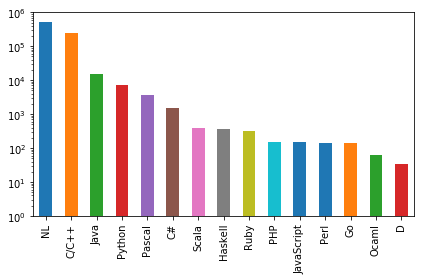

In [3]:
# quick review

display(df.head(2))
display(df.tail(2))
print(df['text'][787270],'\n')

print('data types:\n====================')
display(df.dtypes)

print('null values check:\n====================')
display(df.isnull().sum().sort_values(ascending=False))

valc = df['lang'].value_counts()
print('value counts: {}\n====================\n{}'.format(valc.sum(), valc))

df['lang'].value_counts().plot(kind='bar', log='true')
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()



# Split dataset : Train and Test sets (kfolds)

In [4]:
# -- prepare --
df['label'] = np.where(df['lang']=='NL', 'EMAIL', 'CODE')
df.drop(columns=['id'], inplace=True)
display(df.sample(10))

,lang,text,label
759320,C/C++,< iostream > #include < algorithm > #include <...,CODE
318004,NL,could you mark up the llc opinion and fax it t...,EMAIL
785855,C/C++,< bits using namespace std ; #define NMax #LON...,CODE
596573,C/C++,< iostream > using namespace std ; #define aa ...,CODE
13364,NL,i think i can scrounge one up\r\n\r\n\r\n \r...,EMAIL
230581,NL,thanks for your voice mail message. we are i...,EMAIL
392287,NL,please begin your focus on increasing eol liqu...,EMAIL
371067,NL,if you have an equipment inventory sheet on yo...,EMAIL
330639,NL,\r\n\r\nin response to your request listed bel...,EMAIL
113300,NL,"hi mark and mark,\r\n\r\nover the past few wee...",EMAIL


# Setup learning splits - StratifiedKFold

In [5]:
# -- split --

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

NUM_FOLDS = 2
skfold = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True)

train_test_splits = skfold.split(df['text'], df['label'])

# usage : for train_index, test_index in train_test_splits
print('splits ready :',train_test_splits)

splits ready : <generator object _BaseKFold.split at 0x0000020FABC01830>


# Feature extraction : BOW :: TF-IDF

## Text feature extraction helpers - preprocess, tokenize, analyzer 

In [6]:
# text feature helpers

# doc string to doc string
def preprocessText(text):
    return text.lower()

# doc string to doc token list
TOKEN_DELIMS = '[^\w\']|\s'
TOKEN_MIN_LEN = 2
TOKEN_STOPWORDS = {'enron', 'for', '<', '>', 'a', 'subject', 'to', 'from'}
TOKEN_NUMERIC = ''
TOKEN_DATASET_NUMERIC = 'LONGNUM' # dataset numeric after stripping
def tokenizer(text):
        
    def normalizeToken(tk):
        return tk
    
    def getToken(tk):
        if len(tk) < TOKEN_MIN_LEN:
            return None
        if tk==TOKEN_DATASET_NUMERIC or str.isnumeric(tk):
            return TOKEN_NUMERIC
        if tk in TOKEN_STOPWORDS:
            return None
        return tk
    
    text = re.split(TOKEN_DELIMS, text)
    tokens = [getToken(word) for word in text]
    tokens = [tk for tk in tokens if tk]
    return tokens

# doc string to doc token list
def analyzer(text):
    return tokenizer(preprocessText(text))


# test
def test_tokenize(test_entry):
    print('\n\n=======TOKENIZED=======\n\n', tokenizer(test_entry))
    print('\n\n=======ORIGINAL=======\n\n' ,test_entry)

# 787270 129068
test_entry = df['text'][787270]
test_tokenize(test_entry)

#target_tokens = set()



=======TOKENIZED=======

 ['iostream', 'include', 'stdio', 'include', 'algorithm', 'include', 'cmath', 'include', 'vector', 'include', 'map', 'using', 'namespace', 'std', 'long', 'long', 'mx', 'int', 'main', 'cin', 'cin', 'mx', 'max', 'mx', 'if', 'mx', 'cout', 'No', 'return', 'cout', 'Yes']


=======ORIGINAL=======

 < iostream > #include < stdio . h > #include < algorithm > #include < cmath > #include < vector > #include < map > using namespace std ; long long i j n m A [ #LONGNUM# ] t B [ #LONGNUM# ] l mx = #LONGNUM# ; int main ( ) { cin > > n ; for ( i = #LONGNUM# ; i < = n ; i + + ) { cin > > A [ i ] ; mx = max ( mx A [ i ] ) ; } for ( i = #LONGNUM# ; i < = n ; i + + ) if ( mx%A [ i ] ! = #LONGNUM# ) { cout < < No ; return #LONGNUM# ; } cout < < Yes ; }


# Vectorize, Train and Test

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

n_features = 80
vectorizers = []
aucs = []
out_of_fold_labels = df['label']
out_of_fold_predicts = df['label'].copy() # predictions over **test** sets
for i, (train_idxs, test_idxs) in enumerate(train_test_splits):

    #  vectorize
    # --------------------------------------------------------
    X_raw_train = df['text'][train_idxs]
    y_train = df['label'][train_idxs]
    X_raw_test = df['text'][test_idxs]
    y_test = df['label'][test_idxs]

    vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                               max_features = n_features,
                               preprocessor = None,
                               tokenizer = None,
                               analyzer = tokenizer,
                               use_idf = True,
                               stop_words = 'english')

    print('vectorization of split #{} ...'.format(i), end='')
    t0 = time()
    X_vec_matrix = vectorizer.fit_transform(X_raw_train)
    print(' matrix shape:', X_vec_matrix.shape, end='')
    print(' done in {:.2f}s'.format(time() - t0), end='')
    
    X_train = X_vec_matrix
    X_test = vectorizer.transform(X_raw_test)
    
    # --------------------------------------------------------
    
    
    #  train
    # --------------------------------------------------------
    model = DecisionTreeClassifier(max_depth=5)
    print('\ndecision tree of split #{} ...'.format(i), end='')
    t0 = time()
    model.fit(X_vec_matrix, y_train)
    print(' done in {:.2f}s'.format(time() - t0), end='')
    # --------------------------------------------------------
    
    
    #  test
    # --------------------------------------------------------
    # predictions
    y_predict = model.predict_proba(X_test) # [class1_prob,class2_prob,...] use [:,0]
    out_of_fold_predicts[test_idxs] = model.predict(X_test) # update out-of-fold test sets
    # acccuracy
    auc = roc_auc_score(y_test=='CODE', y_predict[:,0])
    aucs.append(auc)
    print(' -> auc is {:.5f}'.format(auc))
    
    # --------------------------------------------------------
    
    print()
    if i==1:
        pass
        #break

print ('Total stats:', 'mean', np.mean(aucs), 'std', np.std(aucs))

vectorization of split #0 ... matrix shape: (393635, 80) done in 154.65s
decision tree of split #0 ... done in 5.43s -> auc is 0.99650

vectorization of split #1 ... matrix shape: (393637, 80) done in 155.02s
decision tree of split #1 ... done in 5.16s -> auc is 0.99612

Total stats: mean 0.996314527082 std 0.000190424751272


## ▲▲ TRAINING PROGRESS ABOVE▲▲


,feature token,score
33,int,0.969987
19,do,0.012169
30,if,0.007008
4,ans,0.003530
40,main,0.002396
54,please,0.002383
78,you,0.000631
63,the,0.000551
72,we,0.000529
73,while,0.000356


Feature tokens importances:


<Figure size 3200x1000 with 0 Axes>

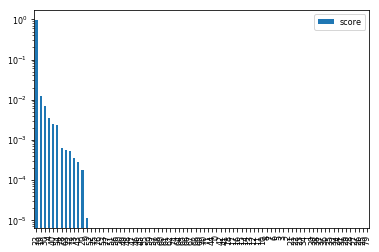

In [8]:
#print('Vectorizer Vocabulary:\n', vectorizer.vocabulary_)

features_score = pd.DataFrame(vectorizer.get_feature_names(), columns=['feature token'])
features_score['score'] = model.feature_importances_
features_score.sort_values('score', ascending=False, inplace=True)
display(features_score)


# bar plot
print('Feature tokens importances:')
plt.figure(figsize=(16, 5), dpi=200), plt.rc("font", size=8)
ax = features_score.plot(kind='bar', log=True)
plt.xticks(rotation='vertical')
plt.show()


In [9]:
# test some objects and return types 
def test_objects():
    vec = vectorizer
    #print(vec)

    #print(X_test)

    print('\n\ny_test:\n', y_test[:10], len(y_test), y_test.shape)

    print('\n\nscores per class:\n', y_predict[:10], len(y_predict), y_predict.shape)

    print('\n\nscores:\n' ,y_predict[:,0])


    auc = roc_auc_score(y_test=='CODE', y_predict[:,0])


    analyzer_check = vec.build_analyzer()
    #print('Test vectorizer setup: ',analyzer_check(test_entry)==tokenizer(test_entry))  
    #print('Vocabulary: ', vec.vocabulary_)

#test_objects()



### Analyse misfits - confusion matrix, dist, samples

In [10]:
from collections import Counter

lang_vals = model.classes_ # get class names from model
conf = pd.DataFrame(confusion_matrix(out_of_fold_labels, out_of_fold_predicts), columns=lang_vals)
conf.index = lang_vals
conf = conf/conf.sum()
print('\nConfusion matrix (out of entire smaple set, row is TrueLabel):')
display(conf)


misfits = df[out_of_fold_labels != out_of_fold_predicts]


print('\nmistfit distribution (out of mistifs only):')
totals = Counter(df['lang'])
for l, c in Counter(misfits['lang']).items():
    print ('{}: {:.2f}'.format(l, c * 100.0 / totals[l]))
    
    
display(misfits.sample(20))
    



Confusion matrix (out of entire smaple set, row is TrueLabel):


,CODE,EMAIL
CODE,0.996632,0.003938
EMAIL,0.003368,0.996062



mistfit distribution (out of mistifs only):
NL: 0.17
Pascal: 8.49
PHP: 31.97
C/C++: 0.16
Ruby: 22.01
Java: 1.75
Scala: 43.24
Python: 5.79
Ocaml: 63.49
JavaScript: 54.42
Perl: 42.66
C#: 8.04
Haskell: 20.94
D: 8.82


,lang,text,label
780084,Pascal,x : extended ; l p q : longint ; begin readln ...,CODE
130632,NL,media inquiries: chris stockton\r\n ...,EMAIL
256183,NL,\r\n[image]=09[image]=09[image]=09\r\n[image]=...,EMAIL
758989,C#,System ; using System . Collections . Generic ...,CODE
701080,Haskell,= getLine > > = print . product . solve . read...,CODE
777706,C/C++,< bits typedef long long ll ; using namespace ...,CODE
746724,Scala,java . io . _ import java . util . ArrayList i...,CODE
159505,NL,the weekly ferc report and state government re...,EMAIL
778766,Scala,java . io . PrintWriter import java . util . S...,CODE
716702,JavaScript,= parseInt ( readline ( ) . split ( ) ) ; B = ...,CODE


### DecisionTree to Python code maker - adapted for p3

In [11]:
# Decision Tree to Python code maker - adapted for p3

# http://chrisstrelioff.ws/sandbox/2015/06/08/decision_trees_in_python_with_scikit_learn_and_pandas.html
# http://stackoverflow.com/a/30104792

def get_code(tree, feature_names, spacer_base='    '):
    left      = tree.tree_.children_left
    right     = tree.tree_.children_right
    threshold = tree.tree_.threshold
    features  = [feature_names[i] for i in tree.tree_.feature]
    value = tree.tree_.value
    target_names = tree.classes_

    def recurse(left, right, threshold, features, node, depth):
        spacer = spacer_base * depth
        if threshold[node] != -2:
            # replace <= with > - it reads better for this problem
            print (spacer + 'if vec_dict.get(\'' + features[node] + '\', 0) > ' + str(threshold[node]) + ':')
            #print (spacer + 'if contains(\'' + features[node] + '\'):')
            if right[node] != -1:
                recurse(left, right, threshold, features, right[node], depth + 1)
            print (spacer + 'else: # below threshold for \'' + features[node] + '\'')
            #print (spacer + 'else: # doesn\'t contain \'' + features[node] + '\'')
            if left[node] != -1:
                recurse(left, right, threshold, features, left[node], depth + 1)
        else:
            target = value[node]
            
            total_sum = np.sum(target)
            target_name = target_names[target.argmax()]
            target_count = target.max()

            print ((spacer + 'return \'{}\' # --> ({:.4f}, {:.2f}/{:.2f} examples)')\
                   .format(target_name, target_count / total_sum, target_count, total_sum) )

    print('def dt_decider(vec_dict):')
    recurse(left, right, threshold, features, 0, 1)

In [12]:
get_code(model, feature_names=vectorizer.get_feature_names())

def dt_decider(vec_dict):
    if vec_dict.get('int', 0) > 0.0123351290822:
        if vec_dict.get('please', 0) > 0.00419167522341:
            if vec_dict.get('int', 0) > 0.457087785006:
                return 'CODE' # --> (1.0000, 6.00/6.00 examples)
            else: # below threshold for 'int'
                return 'EMAIL' # --> (1.0000, 215.00/215.00 examples)
        else: # below threshold for 'please'
            if vec_dict.get('we', 0) > 0.0554827749729:
                if vec_dict.get('main', 0) > 0.0099976612255:
                    return 'CODE' # --> (1.0000, 27.00/27.00 examples)
                else: # below threshold for 'main'
                    if vec_dict.get('be', 0) > 0.331199407578:
                        return 'CODE' # --> (1.0000, 1.00/1.00 examples)
                    else: # below threshold for 'be'
                        return 'EMAIL' # --> (1.0000, 66.00/66.00 examples)
            else: # below threshold for 'we'
                if vec_dict.get('mes

# Manual Tester

In [25]:
sample_text1 = '''

Dear Carlos

On behalf of Hispanoacme and myself, I should like to congratulate you on the high mark you scored during the selection process and now welcome you to our company. We very much hope you will settle in and that this new step in your career proves a total success.

As you already know, Paco Méndez will introduce you to your colleagues and help you to familiarise yourself with your new position. If you need anything, please do not hesitate to contact the Human Resources Department, where I shall be only too glad to help out.

Regards call me at +972-55852-523

Joaquín Bustamante

Manager of Human Resources

'''

sample_text2 = '''
#include <stdio.h>
int main()
{
    int n, i, flag = 0;

    printf("Enter a positive integer: ");
    scanf("%d",&n);

    for(i=2; i<=n/2; ++i)
    {
        // condition for nonprime number
        if(n%i==0)
        {
            flag=1;
            break;
        }
    }

    if (flag==0)
        printf("%d is a prime number.",n);
    else
        printf("%d is not a prime number.",n);
    
    return 0;
}


'''

sample_text3 = '''

Hi Missy,
please include a thing for the other, or else I'll have to include another thing for the stuff.
If we can do it that's great!

Thanks, 
Big Boss Baby +972-55852-523

'''

sample_text4 = '''


for int i=1 i<5 i++ 
     if john='lala' {
     this is a code
     }

'''


sample_text5 = df['text'][787270]


sample_text6 = '''
        algorithm - C Array sorting tips - Stack Overflow
                        Stack Overflow
                        new
                            Stack Overflow for Teams
                            A private, secure home for your team's questions and answers.
                            Learn more
            Questions
            Developer Jobs
            Tags
            Users
                        Log In
                        Sign Up
            current community
            Stack Overflow
            help
                    chat
            Meta Stack Overflow
your communities            
Sign up or log in to customize your list.
            more stack exchange communities
            company blog
                            Tour
                                Start here for a quick overview of the site
                        Help Center
                            Detailed answers to any questions you might have
                                Meta
                                    Discuss the workings and policies of this site
                                About Us
                                    Learn more about Stack Overflow the company
                                Business
                                    Learn more about hiring developers or posting ads with us
            Join Stack Overflow to learn, share knowledge, and build your career.
                Email Sign Up
                or sign in with
                                                Google
                                                Facebook
                    C Array sorting tips
        Ask Question
        up vote
        23
        down vote
        favorite
        11
       a=[1,3,6,7,1,2]
Which is the best sorting technique to sort the following array and if there are duplicates how to handle them.
Also which is the best sorting technique of all....
 void BubbleSort(int a[], int array_size)
 {
 int i, j, temp;
 for (i = 0; i < (array_size - 1); ++i)
 {
      for (j = 0; j < array_size - 1 - i; ++j )
      {
           if (a[j] > a[j+1])
           {
                temp = a[j+1];
                a[j+1] = a[j];
                a[j] = temp;
           }
      }
 }
 }   
        c algorithm sorting 
share|improve this question        
        edited Oct 8 '10 at 20:32
        Donotalo
            7,8031961104
        asked Oct 8 '10 at 20:03
        Rajeev
            13.7k59145236
                    1
                See: en.wikipedia.org/wiki/Sorting_algorithm
                    – Donotalo
                Oct 8 '10 at 20:13
                    2
                There is no "best sorting technique of all", it depends on the size of your data and if it is somewhat sorted at the beginning. I'd suggest you to read en.wikipedia.org/wiki/… and the whole Wikipedia article as well.
                    – schnaader
                Oct 8 '10 at 20:13
                "best" depends on the data and other constraints: memory, speed, how mis sorted to start. quicksort is a great compromise among those. bubble sort is a best for small memory. What do you want to accomplish?
                    – dawg
                Oct 8 '10 at 20:16
                The best (if best == fastest) sorting technique would be to get the data such that it's already sorted.
                    – Nick T
                Oct 8 '10 at 20:17
                "following array" = "preceding array"? If yes, the fastest is to write it down sorted. Seriously, I do this in generated code.
                    – Peter G.
                Oct 8 '10 at 20:41
                 | 
            show 4 more comments
                                5 Answers
                                5
            active
            oldest
            votes
        up vote
        38
        down vote
        accepted
In C, you can use the built in qsort command: 
int compare( const void* a, const void* b)
{
     int int_a = * ( (int*) a );
     int int_b = * ( (int*) b );
     if ( int_a == int_b ) return 0;
     else if ( int_a < int_b ) return -1;
     else return 1;
}
qsort( a, 6, sizeof(int), compare )
see: http://www.cplusplus.com/reference/clibrary/cstdlib/qsort/
To answer the second part of your question: an optimal (comparison based) sorting algorithm is one that runs with O(n log(n)) comparisons. There are several that have this property (including quick sort, merge sort, heap sort, etc.), but which one to use depends on your use case.
As a side note, you can sometime do better than O(n log(n)) if you know something about your data - see the wikipedia article on Radix Sort
share|improve this answer                    
        edited Jul 15 '15 at 4:28
        answered Oct 8 '10 at 20:09
        Alex Reece
            1,0861227
                    4
                @Alex: if you want it fast, at least provide a decent compare function! qsort does not need the returned values to be -1, 0, 1, but "any negative number", 0, "any positive number", hence you just have to do return *((int*)a)-*((int*)b); which is much faster than your proposal.
                    – kriss
                Oct 8 '10 at 21:02
                    6
                @kriss: your comparison isn't well-defined in case of integer overflow; therefore, one often sees things like  return (a > b) - (a < b)
                    – Christoph
                Oct 8 '10 at 22:04
                    1
                @Stephen Canon: Agreed, you should use formulas like Christoph's when you know nothing of your data range and overflow can happen. In practical case I never saw a single occurence when dealing with signed numbers dans I didn't had some rough idea of the data range (and my formulas is also fine for unsigneds). My point was mostly that compare API result type is not -1,0,1 (or we couldn't even use strcmp for comparing char*).
                    – kriss
                Oct 9 '10 at 2:34
                    2
                @kriss: This use of notation is simply wrong. Even if it's randomized, it can hit cases where it takes quadratic time. Therefore, the big O is quadratic. Big O always means worst case. Use different notations for ridiculous "average case" complexity estimates.
                    – R..
                Oct 9 '10 at 9:45
                    2
                @kriss: If I say an algorithm is O(f(n)) in time, that means the time it takes to run is bounded by a constant multiple of f(n), where the particular constant is implementation-dependent but constant within an implementation, for all possible inputs. Claiming quicksort is O(n log n) is as absurd as claiming if (rand()==42) return find_prime_factors(n); else return NULL; is O(1) with respect to n.
                    – R..
                Oct 9 '10 at 22:10
                 | 
            show 13 more comments
        up vote
        11
        down vote
In your particular case the fastest sort is probably the one described in this answer. It is exactly optimized for an array of 6 ints and uses sorting networks. It is 20 times (measured on x86) faster than library qsort. Sorting networks are optimal for sort of fixed length arrays. As they are a fixed sequence of instructions they can even be implemented easily by hardware.
Generally speaking there is many sorting algorithms optimized for some specialized case. The general purpose algorithms like heap sort or quick sort are optimized for in place sorting of an array of items. They yield a complexity of O(n.log(n)), n being the number of items to sort. 
The library function qsort() is very well coded and efficient in terms of complexity, but uses a call to some comparizon function provided by user, and this call has a quite high cost.
For sorting very large amount of datas algorithms have also to take care of swapping of data to and from disk, this is the kind of sorts implemented in databases and your best bet if you have such needs is to put datas in some database and use the built in sort.
share|improve this answer                    
        edited May 23 '17 at 12:25
        Community♦
            11
        answered Oct 8 '10 at 20:13
        kriss
            15.8k117199
                +1 for sorting networks
                    – R..
                Oct 9 '10 at 3:25
                add a comment | 
        up vote
        5
        down vote
Depends
It depends on various things. But in general algorithms using a Divide-and-Conquer / dichotomic approach will perform well for sorting problems as they present interesting average-case complexities.
Basics
To understand which algorithms work best, you will need basic knowledge of algorithms complexity and big-O notation, so you can understand how they rate in terms of average case, best case  and worst case scenarios. If required, you'd also have to pay attention to the sorting algorithm's stability.
For instance, usually an efficient algorithm is quicksort. However, if you give quicksort a perfectly inverted list, then it will perform poorly (a simple selection sort will perform better in that case!). Shell-sort would also usually be a good complement to quicksort if you perform a pre-analysis of your list.
Have a look at the following, for "advanced searches" using divide and conquer approaches:
quicksort
shellsort
mergesort
And these more straighforward algorithms for less complex ones:
bubblesort
selection sort
insert sort
Further
The above are the usual suspects when getting started, but there are countless others.
As pointed out by R. in the comments and by kriss in his answer, you may want to have a look at HeapSort, which provides a theoretically better sorting complexity than a quicksort (but will won't often fare better in practical settings). There are also variants and hybrid algorithms (e.g. TimSort).
share|improve this answer                    
        edited Jan 18 '14 at 19:08
        answered Oct 8 '10 at 20:23
        haylem
            18.8k35485
                If you provide a perfectly inverted list to quicksort it will degenerate only in the most naive implementation (allways take head of the list as pivot) and even then it won't be worse that BubbleSort. The naive Quicksort would also perform poorly with an already sorted list. But very simple changes to the algorithm are enough to avoid the problem (extract several numbers from the list as potential pivot and choose median as pivot).
                    – kriss
                Oct 8 '10 at 20:56
                @kriss: Correct. But this is a CS-learning question, and so I just talk about the theoretical and basic implementation of each of these approaches. Obviously you can tweak algorithms and minimize these side-effects, but as the OP is asking about general sorting issues, I think it's more in-line to pinpoint these issues.
                    – haylem
                Oct 8 '10 at 23:33
                @haylem: it's indeed probably a learning question, but the risk speaking about naive implementations is for the reader to believe that the library call qsort is a naive implementation of QuickSort, which it is not, and would degenerate on sorted data set. If I remember correctly it is not even a QuickSort in most implementations.
                    – kriss
                Oct 9 '10 at 2:41
                You left out heap sort, which is quite arguably the ideal sort (O(1) space and O(n log n) time).
                    – R..
                Oct 9 '10 at 3:24
                @kriss: Thanks for the corrections.
                    – haylem
                Oct 9 '10 at 9:58
                 | 
            show 1 more comment
        up vote
        2
        down vote
The best sorting technique of all generally depends upon the size of an array. Merge sort can be the best of all as it manages better space and time complexity according to the Big-O algorithm (This suits better for a large array). 
share|improve this answer                    
        answered Dec 1 '16 at 19:14
        Pankti
            315112
                add a comment | 
        up vote
        1
        down vote
I'd like to make some changes:
In C, you can use the built in qsort command:
int compare( const void* a, const void* b)
{
   int int_a = * ( (int*) a );
   int int_b = * ( (int*) b );
   // an easy expression for comparing
   return (int_a > int_b) - (int_a < int_b);
}
qsort( a, 6, sizeof(int), compare )
share|improve this answer                    
        answered Sep 12 '11 at 14:52
        Thomas
            607147
                add a comment | 
                            Your Answer
    draft saved
    draft discarded
                        Sign up or log in
                             Sign up using Google
                             Sign up using Facebook
                             Sign up using Email and Password
                                Post as a guest
                    Name
                    Email
                        Post as a guest
                    Name
                    Email
                                    discard
By posting your answer, you agree to the privacy policy and terms of service.
Not the answer you're looking for?                            Browse other questions tagged c algorithm sorting  or ask your own question.                        
                                asked
                                7 years, 7 months ago
                                viewed
                                    68,582 times
                                    active
                                    3 months ago
	Linked
		0
	How to write qsort comparison function for integers?
		358
	Fastest sort of fixed length 6 int array
		9
	Meaning of average complexity when using Big-O notation
		0
	what's the fastest kind of sorting an array?
		-1
	Sorting 2D array
		0
	Sorting an struct array in C with qsort function
		0
	Sort an array in C++
		0
	What should I do for sort array?
                    Related
                        1345Sort a Map<Key, Value> by values2774How do I sort a dictionary by value?997Sorting an array of JavaScript objects1721Sort array of objects by string property value in JavaScript848Sort Multi-dimensional Array by Value358Fastest sort of fixed length 6 int array962Easy interview question got harder: given numbers 1..100, find the missing number(s)617Sorting 1 million 8-digit numbers in 1 MB of RAM3460How to pair socks from a pile efficiently?806Swift performance: sorting arrays
            Hot Network Questions
                    Where does the use of tensors to describe orientation dependence of physical phenomena, arise from?
                    How do you set up this Tricky u-sub?
                    Python - "test".count('')
                    Is it okay to regularly turn off lamps (2) via a power strip rather than their individual switches?
                    Can a Medusa's head still be used to petrify after it's dead?
                    How to prepend a line to all files in a directory?
                    Finding the slope at different points in a sigmoid curve
                    Why was Spider-Man the only person to feel any physical sensation from this event in Infinity War?
                    Dangerous pending task in world managing A.I
                    Can cameras and LCD screens replace cabin windows?
                    Can eggboxes really be used to treat a room? If so, how?
                    How to get rid of this white fungus
                    Implicit differentiation involving a sliding ladder
                    Why was nil a reserved word in Pascal?
                    Confused about using a password that "would take centuries to break"
                    What does it take for a lower-ranked university to compete with a top-ranked one?
                    Why does the BBC claim that there is 'no clear winner' in England's local elections?
                    Field appearing NULL in tests
                    Why is it so easy to become king of Wakanda?
                    Find What or who am I?
                    How to make the reader think that the *character's* logic is flawed instead of the author's?
                    Big star initially shows gratitude (6)
                    Descent of étale torsors
                    While in Phd I developed a lot of code that I want to turn into start-up. Can I do this?
            more hot questions
        question feed
lang-c
                        Stack Overflow
                            Questions
                                Jobs
                                Developer Jobs Directory
                                     Salary Calculator
                                                            Help
                                Mobile
                        Products
                            Teams
                            Talent
                            Ads
                            Enterprise
                    Company
                            About
                                                Press
                            Work Here
                        Legal
                        Privacy Policy
                            Contact Us
                        Stack Exchange Network
                            Technology
                            Life / Arts
                            Culture / Recreation
                            Science
                            Other
                Stack Overflow
                Server Fault
                Super User
                Web Applications
                Ask Ubuntu
                Webmasters
                Game Development
                TeX - LaTeX
                Software Engineering
                Unix & Linux
                Ask Different (Apple)
                WordPress Development
                Geographic Information Systems
                Electrical Engineering
                Android Enthusiasts
                Information Security
                Database Administrators
                Drupal Answers
                SharePoint
                User Experience
                Mathematica
                Salesforce
                ExpressionEngine® Answers
                Stack Overflow em Português
                Blender
                Network Engineering
                Cryptography
                Code Review
                Magento
                Software Recommendations
                Signal Processing
                Emacs
                Raspberry Pi
                Stack Overflow на русском
                Programming Puzzles & Code Golf
                Stack Overflow en español
                Ethereum
                Data Science
                Arduino
                Bitcoin
                            more (29)
                Photography
                Science Fiction & Fantasy
                Graphic Design
                Movies & TV
                Music: Practice & Theory
                Worldbuilding
                Seasoned Advice (cooking)
                Home Improvement
                Personal Finance & Money
                Academia
                Law
                            more (15)
                English Language & Usage
                Skeptics
                Mi Yodeya (Judaism)
                Travel
                Christianity
                English Language Learners
                Japanese Language
                Arqade (gaming)
                Bicycles
                Role-playing Games
                Anime & Manga
                Puzzling
                Motor Vehicle Maintenance & Repair
                            more (33)
                MathOverflow
                Mathematics
                Cross Validated (stats)
                Theoretical Computer Science
                Physics
                Chemistry
                Biology
                Computer Science
                Philosophy
                            more (10)
                Meta Stack Exchange
                Stack Apps
                API
                Data
                Area 51
                    Blog
                    Facebook
                    Twitter
                    LinkedIn
site design / logo © 2018 Stack Exchange Inc; user contributions licensed under cc by-sa 3.0
                            with attribution required.
                    rev 2018.5.8.30318
        Stack Overflow works best with JavaScript enabled'''


sample_text7 = '''

        How to sort an array by passing to a function as pointer using c? - Stack Overflow
                        Stack Overflow
                        new
                            Stack Overflow for Teams
                            A private, secure home for your team's questions and answers.
                            Learn more
            Questions
            Developer Jobs
            Tags
            Users
                        Log In
                        Sign Up
            current community
            Stack Overflow
            help
                    chat
            Meta Stack Overflow
your communities            
Sign up or log in to customize your list.
            more stack exchange communities
            company blog
                            Tour
                                Start here for a quick overview of the site
                        Help Center
                            Detailed answers to any questions you might have
                                Meta
                                    Discuss the workings and policies of this site
                                About Us
                                    Learn more about Stack Overflow the company
                                Business
                                    Learn more about hiring developers or posting ads with us
            Join Stack Overflow to learn, share knowledge, and build your career.
                Email Sign Up
                or sign in with
                                                Google
                                                Facebook
                    How to sort an array by passing to a function as pointer using c?
        Ask Question
        up vote
        -2
        down vote
        favorite
        1
Consider an array, which is passed to the function swap(), as illustrated in the following quote. I want to implemented a variant of this swap() function in order to sort my array.
  These inefficiencies can be removed by an implementation as suggested bu the array concept of the C programming language. The idea is to access array elements through pointers. Another idea is to store addresses that are used multiple times.
void swap(int *p, int *q) {
    int t, ai, aj;
    ai <- *p; aj <- *q;
    if (ai > aj) {
        t <- aj;
        *q <- ai;
        *p <- t;
    }
}
  Looking more closely at this new code reveals that the temporary variable t can be eliminated as well.
I have done it in the following way, but fail to sort the array. Can you check for the error why it does not sort the array?
void swap(int array1[], int array2[])
{
    int temp, ai, aj;
    ai = *array1;
    aj = *array2;
    if (ai > aj) /* For decreasing order use < */
    {
        temp = aj;
        aj = ai;
        ai = temp;
    }
}
int main()
{
    int array[100], n, c, d, swap;
    printf("Enter number of elements\n");
    scanf("%d", &n);
    printf("Enter %d integers\n", n);
    for (c = 0; c < n; c++)
        scanf("%d", &array[c]);
    for (c = 0; c < (n - 1); c++)
    {
        for (d = 0; d < n - c - 1; d++)
        {
            swap(array[c], array[d]);
        }
    }
    printf("Sorted list in ascending order:\n");
    for (c = 0; c < n; c++)
        printf("%d\n", array[c]);
    return 0;
}
        c arrays sorting pointers 
share|improve this question        
        edited Jun 21 '17 at 2:01
        Stargateur
            6,21241440
        asked Jul 27 '16 at 22:19
        Eid
            3210
                does that even compile? I bet the compiler is complaining big time at you
                    – pm100
                Jul 27 '16 at 22:25
                What compiler warnings do you get? Assuming you have them enabled. But "faster than other methods"? Not unless you inline the function for a simple swap.
                    – Weather Vane
                Jul 27 '16 at 22:25
                Yeah, it gives error..
                    – Eid
                Jul 27 '16 at 22:27
                I was not able to call it in the right way: swap(array[c], array[d]); Therefore, the error is here
                    – Eid
                Jul 27 '16 at 22:28
                @weatherVane. Please check and vote. thanks
                    – Eid
                Jun 21 '17 at 1:47
                 | 
            show 5 more comments
                                2 Answers
                                2
            active
            oldest
            votes
        up vote
        2
        down vote
        accepted
1) Sorting only affected local contents.
    temp = aj;
    aj = ai;
    ai = temp;
Code needs to update values referenced by original pointers.
void swap(int array1[], int array2[]){
  int ai = *array1;
  int aj = *array2;
  if (ai > aj) {
    *array1 = aj;
    *array2 = ai;
  }
}
2) Code needs to call the swap() correctly.  It expect pointers, not int.  This implies compiler warnings are not fully enabled.  Be sure to do so - saves you time.
// swap(array[c], array[d]);
swap(&array[c], &array[d]);
share|improve this answer                    
        edited Jul 27 '16 at 22:31
        answered Jul 27 '16 at 22:28
        chux
            70.5k759126
                Yeah, that is true but How can I call it from the main function. Like I have done "swap(array[c], array[d]);", which gives me error
                    – Eid
                Jul 27 '16 at 22:30
                @Eid - you can't possibly use array reference if you are passing an int to the function. You need to at least pass the reference to the function.
                    – alvits
                Jul 27 '16 at 22:35
                function definition : void swap(int array1[], int array2[])..... function call: swap(&array[c],&array[d]);.....Gives the same error
                    – Eid
                Jul 27 '16 at 22:45
                function definition is still wrong:  void swap(int* val1, int* val2)  feel free to check the edit to my answer
                    – user3164339
                Jul 27 '16 at 22:46
                @user3164339 You are mistaken if you think void swap(int array1[], int array2[]) differs in functionality from void swap(int *array1, int *array2).  There are the same.  See stackoverflow.com/questions/8424716/…
                    – chux
                Jul 27 '16 at 23:16
                 | 
            show 4 more comments
        up vote
        1
        down vote
ok , you have declared swap as 
void swap(int array1[], int array2[])
but you call it with
swap(array[c], array[d]);
so the declaration says it takes two int arrays as params but you pass it two ints.
If you want swap (btw it should be called swap_if_needed) to excahnge 2 elements of the arrays then it needs to be declared as
void swap(int array, int idx1, int idx2);
and called by
swap(array,c,d);
I leave it to you to correct the body of swap
If you want to do it like the book then you need to declare swal as
void swap(int *x, int * y);
and call it like this
swap(&array[c], &array[d]);
share|improve this answer                    
        edited Jul 27 '16 at 22:34
        answered Jul 27 '16 at 22:30
        pm100
            22.9k125099
                You are right, but the execution time will not be effected the way you have done. I want to access array elements using pointers
                    – Eid
                Jul 27 '16 at 22:32
                Perhaps void swap(int *array, int idx1, int idx2);?  (need *)
                    – chux
                Jul 27 '16 at 22:33
                @Eid see edit   ..
                    – pm100
                Jul 27 '16 at 22:35
                calling function: swap(array, c, d); ....and the function definition....void swap(int *ar, int c, int d)...Still does not work
                    – Eid
                Jul 27 '16 at 22:40
                you need to repost your code to show what you have now, and say whats 'not working'
                    – pm100
                Jul 27 '16 at 22:48
                add a comment | 
                            Your Answer
    draft saved
    draft discarded
                        Sign up or log in
                             Sign up using Google
                             Sign up using Facebook
                             Sign up using Email and Password
                                Post as a guest
                    Name
                    Email
                        Post as a guest
                    Name
                    Email
                                    discard
By posting your answer, you agree to the privacy policy and terms of service.
Not the answer you're looking for?                            Browse other questions tagged c arrays sorting pointers  or ask your own question.                        
                                asked
                                1 year, 9 months ago
                                viewed
                                    1,000 times
                                    active
                                    2 months ago
	Linked
		4
	Difference between int [] and int* as function arguments
                    Related
                        2518What are the differences between a pointer variable and a reference variable in C++?2870Create ArrayList from array3110How do I check if an array includes an object in JavaScript?2777How to append something to an array?1406With arrays, why is it the case that a[5] == 5[a]?2774How do I sort a dictionary by value?1721Sort array of objects by string property value in JavaScript5736How do I remove a particular element from an array in JavaScript?3642For-each over an array in JavaScript?3460How to pair socks from a pile efficiently?
            Hot Network Questions
                    How do you set up this Tricky u-sub?
                    Is the "legacy" of Marx & Engels unwarranted?
                    Is it okay to regularly turn off lamps (2) via a power strip rather than their individual switches?
                    What am I - An enigmatic haiku
                    How to update picklist using REST API
                    Implicit differentiation involving a sliding ladder
                    Let's play Mölkky!
                    Can microspikes replace crampons when crossing ice in summer?
                    Can an argument be valid even though one of its premises is false?
                    Automatically apply a kern rule for all characters that follow a specific character
                    How would I obtain the square root of this multinomial?
                    Source of the Napoleon "God/Devil/immortal" quote
                    Why was only one person used as the template for the Clone Army?
                    Confused about using a password that "would take centuries to break"
                    Big star initially shows gratitude (6)
                    Creating the Twitter verified badge using TikZ
                    What was Steve Rogers's phone number?
                    What does "As in" in here?
                    How can a colony of teleporters make the most money while keeping their teleportation a secret?
                    Is there a way to provide serial tasks on terminal while a task is executing (without using a file)?
                    I can turn your pet into a god
                    Better way of designing memory layout in tikz
                    If the human body consists of 60% water why can't we put out fire with our body?
                    Why was Spider-Man the only person to feel any physical sensation from this event in Infinity War?
            more hot questions
        question feed
lang-c
                        Stack Overflow
                            Questions
                                Jobs
                                Developer Jobs Directory
                                     Salary Calculator
                                                            Help
                                Mobile
                        Products
                            Teams
                            Talent
                            Ads
                            Enterprise
                    Company
                            About
                                                Press
                            Work Here
                        Legal
                        Privacy Policy
                            Contact Us
                        Stack Exchange Network
                            Technology
                            Life / Arts
                            Culture / Recreation
                            Science
                            Other
                Stack Overflow
                Server Fault
                Super User
                Web Applications
                Ask Ubuntu
                Webmasters
                Game Development
                TeX - LaTeX
                Software Engineering
                Unix & Linux
                Ask Different (Apple)
                WordPress Development
                Geographic Information Systems
                Electrical Engineering
                Android Enthusiasts
                Information Security
                Database Administrators
                Drupal Answers
                SharePoint
                User Experience
                Mathematica
                Salesforce
                ExpressionEngine® Answers
                Stack Overflow em Português
                Blender
                Network Engineering
                Cryptography
                Code Review
                Magento
                Software Recommendations
                Signal Processing
                Emacs
                Raspberry Pi
                Stack Overflow на русском
                Programming Puzzles & Code Golf
                Stack Overflow en español
                Ethereum
                Data Science
                Arduino
                Bitcoin
                            more (29)
                Photography
                Science Fiction & Fantasy
                Graphic Design
                Movies & TV
                Music: Practice & Theory
                Worldbuilding
                Seasoned Advice (cooking)
                Home Improvement
                Personal Finance & Money
                Academia
                Law
                            more (15)
                English Language & Usage
                Skeptics
                Mi Yodeya (Judaism)
                Travel
                Christianity
                English Language Learners
                Japanese Language
                Arqade (gaming)
                Bicycles
                Role-playing Games
                Anime & Manga
                Puzzling
                Motor Vehicle Maintenance & Repair
                            more (33)
                MathOverflow
                Mathematics
                Cross Validated (stats)
                Theoretical Computer Science
                Physics
                Chemistry
                Biology
                Computer Science
                Philosophy
                            more (10)
                Meta Stack Exchange
                Stack Apps
                API
                Data
                Area 51
                    Blog
                    Facebook
                    Twitter
                    LinkedIn
site design / logo © 2018 Stack Exchange Inc; user contributions licensed under cc by-sa 3.0
                            with attribution required.
                    rev 2018.5.8.30318
        Stack Overflow works best with JavaScript enabled
'''

In [20]:
def dt_decider(vec_dict):
    if vec_dict.get('int', 0) > 0.0123351290822:
        if vec_dict.get('please', 0) > 0.00419167522341:
            if vec_dict.get('int', 0) > 0.457087785006:
                return 'CODE' # --> (1.0000, 6.00/6.00 examples)
            else: # below threshold for 'int'
                return 'EMAIL' # --> (1.0000, 215.00/215.00 examples)
        else: # below threshold for 'please'
            if vec_dict.get('we', 0) > 0.0554827749729:
                if vec_dict.get('main', 0) > 0.0099976612255:
                    return 'CODE' # --> (1.0000, 27.00/27.00 examples)
                else: # below threshold for 'main'
                    if vec_dict.get('be', 0) > 0.331199407578:
                        return 'CODE' # --> (1.0000, 1.00/1.00 examples)
                    else: # below threshold for 'be'
                        return 'EMAIL' # --> (1.0000, 66.00/66.00 examples)
            else: # below threshold for 'we'
                if vec_dict.get('message', 0) > 0.0984009876847:
                    if vec_dict.get('main', 0) > 0.0429555773735:
                        return 'CODE' # --> (1.0000, 3.00/3.00 examples)
                    else: # below threshold for 'main'
                        return 'EMAIL' # --> (1.0000, 27.00/27.00 examples)
                else: # below threshold for 'message'
                    if vec_dict.get('ect', 0) > 0.00942249875516:
                        return 'EMAIL' # --> (0.9412, 16.00/17.00 examples)
                    else: # below threshold for 'ect'
                        return 'CODE' # --> (0.9997, 131343.00/131379.00 examples)
    else: # below threshold for 'int'
        if vec_dict.get('do', 0) > 0.572423696518:
            if vec_dict.get('if', 0) > 0.025615233928:
                if vec_dict.get('you', 0) > 0.0554434135556:
                    return 'EMAIL' # --> (1.0000, 18.00/18.00 examples)
                else: # below threshold for 'you'
                    if vec_dict.get('the', 0) > 0.0554221719503:
                        return 'EMAIL' # --> (1.0000, 9.00/9.00 examples)
                    else: # below threshold for 'the'
                        return 'CODE' # --> (0.9951, 1210.00/1216.00 examples)
            else: # below threshold for 'if'
                if vec_dict.get('do', 0) > 0.833772301674:
                    if vec_dict.get('the', 0) > 0.0276307333261:
                        return 'EMAIL' # --> (1.0000, 14.00/14.00 examples)
                    else: # below threshold for 'the'
                        return 'CODE' # --> (0.8547, 153.00/179.00 examples)
                else: # below threshold for 'do'
                    if vec_dict.get('while', 0) > 0.102305486798:
                        return 'CODE' # --> (1.0000, 39.00/39.00 examples)
                    else: # below threshold for 'while'
                        return 'EMAIL' # --> (0.9257, 498.00/538.00 examples)
        else: # below threshold for 'do'
            if vec_dict.get('if', 0) > 0.44429987669:
                if vec_dict.get('you', 0) > 0.0881758108735:
                    return 'EMAIL' # --> (1.0000, 57.00/57.00 examples)
                else: # below threshold for 'you'
                    if vec_dict.get('the', 0) > 0.0964298546314:
                        return 'EMAIL' # --> (1.0000, 30.00/30.00 examples)
                    else: # below threshold for 'the'
                        return 'CODE' # --> (0.8966, 520.00/580.00 examples)
            else: # below threshold for 'if'
                if vec_dict.get('ans', 0) > 0.158078372478:
                    if vec_dict.get('the', 0) > 0.123117119074:
                        return 'EMAIL' # --> (0.8889, 8.00/9.00 examples)
                    else: # below threshold for 'the'
                        return 'CODE' # --> (1.0000, 319.00/319.00 examples)
                else: # below threshold for 'ans'
                    if vec_dict.get('main', 0) > 0.194814741611:
                        return 'CODE' # --> (0.6118, 312.00/510.00 examples)
                    else: # below threshold for 'main'
                        return 'EMAIL' # --> (0.9963, 257417.00/258378.00 examples)

In [21]:
### Save model TfidfVectorizer params to export its transform function

# numpy array that contains the inverse document frequencies (IDFs)
vec_idfs = vectorizer.idf_
display('vec_idfs =', vec_idfs)


# a dictionary that maps each unique token (feature) to its column number on the TF-IDF matrix
vec_volc = vectorizer.vocabulary_
print('vec_volc =', vec_volc)

'vec_idfs ='

array([ 2.55678389,  2.47940697,  2.67818712,  1.79849697,  3.16314064,
        2.56664143,  2.23685888,  2.40706037,  2.28214076,  2.13620968,
        2.92453411,  2.23538104,  2.6761483 ,  2.4369891 ,  2.6732603 ,
        2.43442678,  3.04199952,  2.62816475,  2.95247574,  2.80903008,
        2.92152727,  2.64099471,  3.52671481,  2.93057505,  3.57727227,
        2.8068149 ,  2.1130335 ,  3.49616279,  3.02011935,  3.46421468,
        1.51700431,  1.83515507,  2.50473049,  2.09266766,  1.93150994,
        2.26064507,  3.62129099,  3.37437305,  2.509765  ,  3.25981295,
        2.08439109,  2.97719431,  2.47308082,  2.91738812,  3.22428193,
        2.24723006,  2.88425883,  3.09893226,  2.45522046,  1.87667565,
        1.88733549,  2.4226923 ,  2.79633248,  2.80196794,  2.23133471,
        2.51539134,  3.59070252,  2.19180576,  4.18875518,  2.97510483,
        3.27208245,  2.24064654,  2.1639956 ,  1.62883383,  3.18962974,
        2.02282108,  2.87197875,  3.4375205 ,  2.94298028,  2.14

vec_volc = {'is': 34, 'our': 52, 'have': 26, 'the': 63, 'out': 53, 'of': 49, 'if': 30, 'you': 78, 'would': 76, 'any': 5, 'and': 3, 'on': 50, 'or': 51, 'as': 7, 'it': 35, 'be': 9, 'more': 44, 'not': 48, 'are': 6, 'in': 31, 'time': 66, 'can': 12, 'me': 42, 'your': 79, 'that': 62, 'please': 54, 'cc': 13, 'with': 75, 'com': 15, 'by': 11, 'hou': 28, 'ect': 20, 'pm': 55, 'corp': 16, 'am': 1, 'mail': 39, 'has': 25, 'new': 46, 'we': 72, 'at': 8, 'but': 10, 'this': 65, 'will': 74, 'all': 0, 'do': 19, 'may': 41, 'an': 2, 'gas': 24, 'was': 71, 'no': 47, 'long': 38, 'include': 32, 'up': 68, 'he': 27, 'said': 58, 'http': 29, 'www': 77, 'else': 21, 'they': 64, 'size': 60, 'return': 57, 'first': 23, 'using': 69, 'while': 73, 'message': 43, 'power': 56, 'its': 36, 'energy': 22, 'main': 40, 'define': 18, 'll': 37, 'int': 33, 'cin': 14, 'std': 61, 'ans': 4, 'namespace': 45, 'vector': 70, 'typedef': 67, 'cout': 17, 'scanf': 59}


In [22]:
def vectorize(text):
    tokenized_text = analyzer(text)
    cnt = Counter(tokenized_text)
    vec = {k: (v * vec_idfs[vec_volc[k]]) for k, v in cnt.items() if k in vec_volc}
    norm2 = math.sqrt(sum(v * v for v in vec.values()))
    vec = {k: (v / norm2) for k, v in vec.items()}
    return vec

def vectorize_with_model(text):
    # verify vectorization 
    # ----------------------------------------------------
    f_dict = dict(enumerate(vectorizer.get_feature_names()))
    # print(f_dict)
    #print('should match:')
    #print(fnum_to_name)

    # -------- sample vectorize to dict: 
    mat = vectorizer.transform([sample], copy=True)
    mc = mat.tocoo()
    #print(mat)
    #print(type(mat))
    #print('\n\n')

    vec_dict = {k:v for k,v in zip(mc.col, mc.data)}
    #print(vec_dict)
    #print('\n\n')

    named_vec_dict = {f_dict[k]: v for k,v in vec_dict.items()}
    # print('\n\n=== by vectorizer.transform : sample as dict vector:')
    # print(named_vec_dict)
    return named_vec_dict


def getfreqs(sample):
    tokenized_text = analyzer(sample)
    #print(tokenized_text)

    cnt = Counter(tokenized_text)
    #print('\n\n',cnt)

    # freqs
    freqs = {}
    cnt = Counter(tokenized_text)
    cnt_sum = sum(cnt.values())
    freqs = {k: (v/cnt_sum) for k, v in cnt.items()}
    # print(freqs)
    # print('\n\n')
    return freqs
 





== CLASSIFICATION : CODE  ===

Document token frequencies:


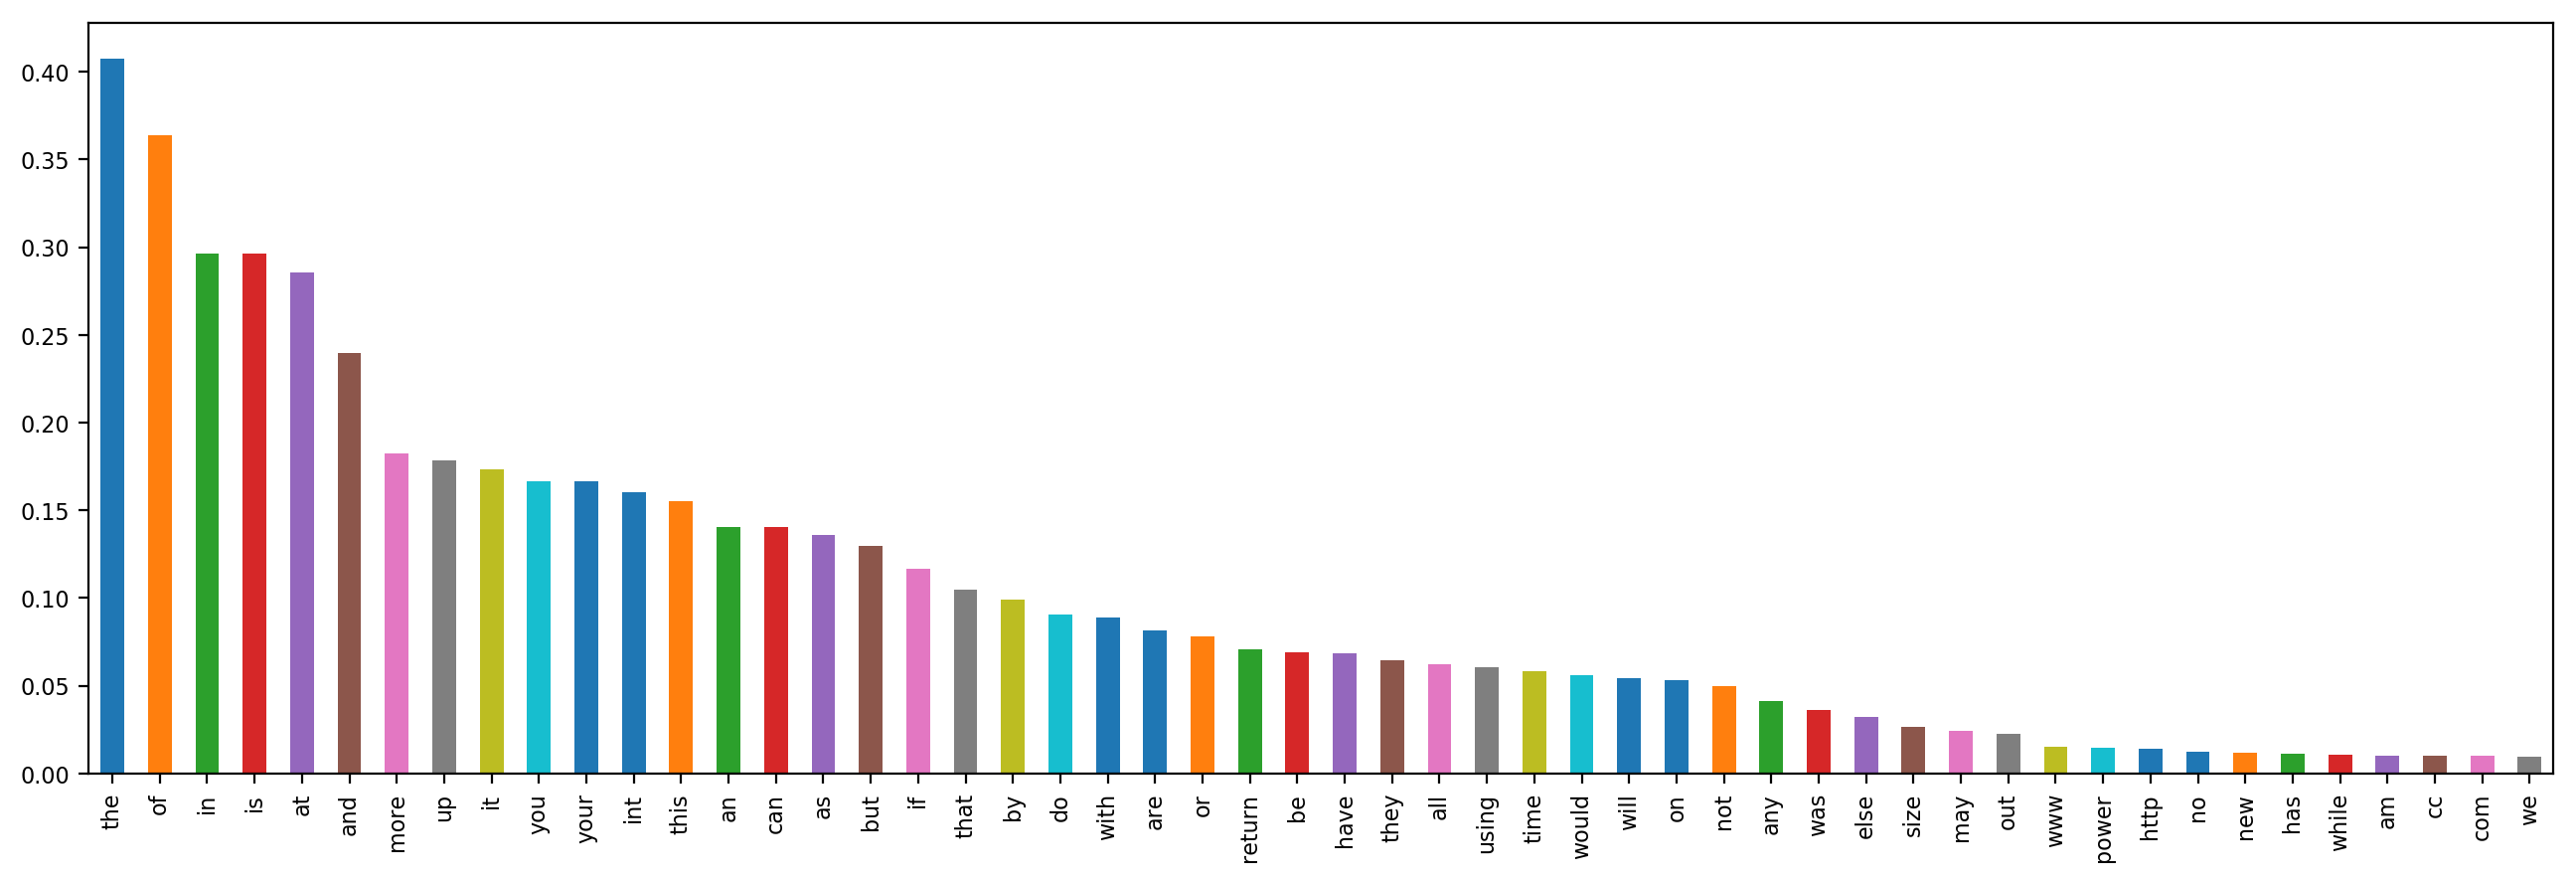

In [27]:
# 1-mail 2-code 3-mail tricky 4-code tricky 5-code_from_ds 6,7-stackoverflow_html
sample = sample_text6

# classify
vec = vectorize(sample)
print('\n\n== CLASSIFICATION :', dt_decider(vec), ' ===\n')



# info - freqs
freqs = getfreqs(sample)

# info - plot
plotdata = vec
# ----------------------------------------------------
# counter to pd
c = pd.Series(plotdata, name='vectorized freqs')
c = c.sort_values(ascending=False)

# frequency normalization
#token_freq = c/c.sum()
#print(token_freq)

# bar plot
print('Document token frequencies:')
fig = plt.figure(figsize=(16, 5), dpi=200), plt.rc("font", size=8)
ax = c.plot(kind='bar')
plt.xticks(rotation='vertical')
plt.show()